# Detecção de Fake News com Graph Neural Networks (GNN)

Este notebook demonstra como usar Redes Neurais em Grafos (GNNs) para detectar fake news em plataformas de mídia social, com base nos padrões de propagação e interação dos usuários. A abordagem explora a estrutura de propagação da informação e as interações para melhorar a acurácia da classificação de notícias falsas.

- **Conjunto de Dados:** User Preference-aware Fake News Detection (UPFD)
- **Referência:** [UPFD: User Preference-aware Fake News Detection](https://arxiv.org/abs/2104.12259)
- **Principais Bibliotecas:** PyTorch Geometric, NetworkX, scikit-learn

O fluxo de trabalho inclui o carregamento e exploração do conjunto de dados, visualização das estruturas de grafos, construção e treinamento do modelo GNN, e avaliação de desempenho.


### Carregar Dados

- **Conjunto de Dados:** User Preference-aware Fake News Detection (UPFD)
- O conjunto de dados contém postagens e metadados sobre como as notícias se espalham no Twitter, incluindo interações de usuários e grafos de propagação.
- Cada amostra é um grafo representando a disseminação de uma notícia, com nós como usuários e arestas como relações de retweet ou compartilhamento.
- O objetivo é classificar cada notícia como real ou falsa com base no padrão de propagação e nas características do conteúdo.

In [48]:
from torch_geometric.datasets import UPFD

test = UPFD(root=".", name="gossipcop", feature="content", split="train")
train = UPFD(root=".", name="gossipcop", feature="content", split="test")
print(f"Test: {len(test)}")
print(f"Train: {len(train)}")

Test: 1092
Train: 3826


In [49]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train, batch_size=128, shuffle=True)
test_loader = DataLoader(test, batch_size=128, shuffle=False)

In [50]:
train._data

Data(x=[219989, 310], edge_index=[2, 216163], y=[3826])

In [51]:
i = 0
train[i]

Data(x=[116, 310], edge_index=[2, 115], y=[1])

In [52]:
train[i].node_stores

[{'x': tensor([[0.4762, 0.4986, 0.5922,  ..., 0.4608, 0.1049, 0.1725],
         [0.4536, 0.5054, 0.6587,  ..., 0.3151, 0.1111, 0.1618],
         [0.4762, 0.4986, 0.5922,  ..., 0.4608, 0.1049, 0.1725],
         ...,
         [0.5111, 0.5022, 0.4710,  ..., 0.2534, 0.0556, 0.4118],
         [0.3148, 0.4548, 0.5879,  ..., 0.5548, 0.1111, 0.2500],
         [0.5202, 0.4781, 0.4777,  ..., 0.8699, 0.0556, 0.2647]]), 'edge_index': tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
            1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
            1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
            1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
            1,   7,  15,  15,  15,  15,  15,  41,  42,  42,  42,  42,  42,  42,
           42, 

### Visualização do Grafo

Visualize a estrutura de um grafo de propagação de notícias. Cada nó representa um usuário e cada aresta representa um retweet ou compartilhamento. Isso ajuda a entender como a informação se espalha e como notícias reais e falsas podem se propagar de maneiras diferentes.

In [53]:
import networkx as nx

def draw_graph(data):
  G = nx.Graph()
  for _, (u, v) in enumerate(data.edge_index.t().tolist()):
    G.add_edge(u, v)
  pos = nx.spring_layout(G, k=2)
  nx.draw(G,pos,with_labels=True)

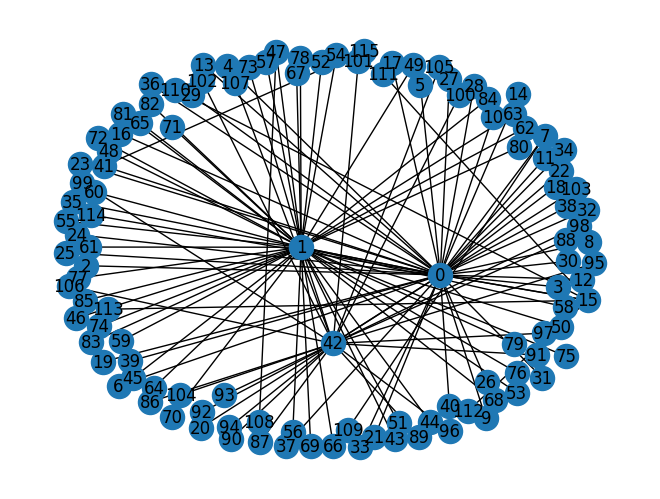

In [54]:
# 0: twitch originario
# 1-n: replicação do twitch
draw_graph(train[i])

In [55]:
real = [data.y.item() for data in train if data.y.item()==0]
fake = [data.y.item() for data in train if data.y.item()==1]
print(f"Real news: {len(real)}")
print(f"Fake news: {len(fake)}")

Real news: 1910
Fake news: 1916


## Modelo de Rede Neural em Grafos (GNN)

Nesta seção, definimos e treinamos uma Rede Neural em Grafos para classificar notícias como reais ou falsas. O modelo utiliza tanto as características do conteúdo quanto a estrutura do grafo de propagação para fazer as previsões.

In [56]:
from dataclasses import astuple
from torch_geometric.nn import global_max_pool, GCN
from torch.nn import Linear, Module
import torch
from sklearn.metrics import accuracy_score, f1_score


class GNN(Module):
  def __init__(self, in_channels, hidden_channels, out_channels, num_layers) -> None:
    super().__init__()

    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.to(self.device)

    self.fst_conv = GCN(in_channels, hidden_channels, num_layers)
    self.snd_conv = GCN(hidden_channels, hidden_channels, num_layers)
    self.trd_conv = GCN(hidden_channels, hidden_channels, num_layers)

    self.lin_news = Linear(in_channels, hidden_channels)
    self.lin0 = Linear(hidden_channels, hidden_channels)
    self.lin1 = Linear(2*hidden_channels, out_channels)


  def forward(self, x, edge_index, batch):
    h = self.fst_conv(x, edge_index).relu()
    h = self.snd_conv(h, edge_index).relu()
    h = self.trd_conv(h, edge_index).relu()

    h = global_max_pool(h, batch)
    h = self.lin0(h).relu()

    root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
    root = torch.cat([root.new_zeros(1), root + 1], dim=0)

    news = x[root]
    news = self.lin_news(news).relu()

    out = self.lin1(torch.cat([h, news], dim=-1))

    return torch.sigmoid(out)




In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(train.num_features, 128, 1, 3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.01, weight_decay=0.01)
loss_fn = torch.nn.BCELoss()


def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fn(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fn(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())

    accuracy, f1 = metrics(all_preds, all_labels)
    return total_loss / len(test_loader.dataset), accuracy, f1

def metrics(preds, gts):
    preds = torch.round(torch.cat(preds))
    gts = torch.cat(gts)

    accuracy = accuracy_score(gts, preds)
    f1 = f1_score(gts, preds)
    return accuracy, f1

In [58]:
for epoch in range(40):
    train_loss = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)

    print(f"Epoch: {epoch:02d} | TrainLoss: {train_loss:.2f} | TestLoss: {test_loss:.2f} | TestAcc: {test_acc:.2f} | TestF1: {test_f1:.2f}")

Epoch: 00 | TrainLoss: 0.71 | TestLoss: 0.69 | TestAcc: 0.51 | TestF1: 0.00
Epoch: 01 | TrainLoss: 0.68 | TestLoss: 0.65 | TestAcc: 0.62 | TestF1: 0.72
Epoch: 02 | TrainLoss: 0.64 | TestLoss: 0.59 | TestAcc: 0.62 | TestF1: 0.37
Epoch: 03 | TrainLoss: 0.62 | TestLoss: 0.55 | TestAcc: 0.89 | TestF1: 0.90
Epoch: 04 | TrainLoss: 0.55 | TestLoss: 0.61 | TestAcc: 0.49 | TestF1: 0.66
Epoch: 05 | TrainLoss: 0.53 | TestLoss: 0.43 | TestAcc: 0.91 | TestF1: 0.92
Epoch: 06 | TrainLoss: 0.42 | TestLoss: 0.44 | TestAcc: 0.82 | TestF1: 0.84
Epoch: 07 | TrainLoss: 0.45 | TestLoss: 0.41 | TestAcc: 0.79 | TestF1: 0.73
Epoch: 08 | TrainLoss: 0.43 | TestLoss: 0.48 | TestAcc: 0.74 | TestF1: 0.79
Epoch: 09 | TrainLoss: 0.37 | TestLoss: 0.35 | TestAcc: 0.90 | TestF1: 0.90
Epoch: 10 | TrainLoss: 0.34 | TestLoss: 0.36 | TestAcc: 0.84 | TestF1: 0.80
Epoch: 11 | TrainLoss: 0.35 | TestLoss: 0.30 | TestAcc: 0.92 | TestF1: 0.93
Epoch: 12 | TrainLoss: 0.30 | TestLoss: 0.29 | TestAcc: 0.93 | TestF1: 0.93
Epoch: 13 | 

## Predição e Resultados

Utilize o modelo GNN treinado para prever se as notícias no conjunto de teste são reais ou falsas. Os resultados são exibidos em um DataFrame, mostrando a probabilidade prevista, a predição binária e o rótulo verdadeiro de cada amostra.

In [65]:
import pandas as pd
df = None
for data in test_loader:
  data = data.to(device)
  pred = model(data.x, data.edge_index, data.batch)
  df = pd.DataFrame(data={
      "pred_final": pred.detach().numpy()[:, 0],
      "pred": torch.round(pred).detach().numpy()[:, 0],
      "true": data.y.numpy()
  })
  break
display(df)

,pred_final,pred,true
0,0.127047,0.0,0
1,0.817529,1.0,1
2,0.987493,1.0,1
3,0.064751,0.0,0
4,0.103356,0.0,0
...,...,...,...
123,0.941143,1.0,1
124,0.137775,0.0,0
125,0.055176,0.0,0
126,0.915103,1.0,1
